# ADULT CENSUS INCOME

This is an adult census income dataset which was  extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AGE>16) , (AGE<100)),(AFNLWGT>1),  (HRSWK>0).

### OBJECTIVES

#### 1) How can we use the demographic and work‐related features (age, education, occupation, hours‐per‐week, etc.) to predict  an individual’s annual income ?

#### 2) What quantifies a higher income? (e.g., via decision‐tree/ensemble methods or logistic‐regression coefficients) to understand which attributes—like education level, occupation, or hours worked—most strongly drive the “> 50K” outcome.

#### 3) How does income vary across various subgroups(gender, race, marital‐status, native‐country) in our dataset?  For example, examine whether certain occupations or educational attainments correlate differently with income for various demographic slices.



### DATA UNDERSTANDING


In [1]:
import pandas as pd
import numpy as np


In [2]:

# Define column names for the Adult dataset
col_names = [
    "age", "workclass", "fnlwgt", "education", "education_num",
    "marital_status", "occupation", "relationship", "race", "sex",
    "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# Reading  the training file
df_train = pd.read_csv("adult.data", header=None, names=col_names, sep=r',\s*',
    engine='python')
# Read the test file (skip the first “|” header row in adult.test)
df_test = pd.read_csv( "adult.test", header=None, names=col_names, sep=r',\s*',
                       engine='python', skiprows=1)
# We Combine into one DataFrame
combined_df = pd.concat([df_train, df_test], ignore_index=True)

print("Combined shape:", combined_df.shape)
combined_df.head()


Combined shape: (48842, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We have established the number of instances in our census income dataframe (48842) and the number of columns (15).
We have also made an overview of the dataFrame by calling the .head() function.
Our target variable is income whether its <=50k  or >50k


In [ ]:
#We try and remove any trailing period from the income strings.
#We use str.rstrip to remove the trailing period from the 'income' column
# This is necessary because the income column in the test set has a trailing period (e.g., " <=50K.")   
combined_df['income'] = combined_df['income'].str.rstrip('.')
# We count of each income category
income_counts = combined_df['income'].value_counts()

# We calculate the percentage of each income category
# We normalize the counts to get percentages
income_percentages = combined_df['income'].value_counts(normalize=True) * 100

# We Combine into a DataFrame for easy viewing
summary_df = pd.DataFrame({
    'Count': income_counts,
    'Percentage (%)': income_percentages.round(2)})

print(summary_df)


       Count  Percentage (%)
<=50K  37155           76.07
>50K   11687           23.93


We can see the percentages and count in our census income data. 
we can elaborate more with a graph to visualize this distribution.

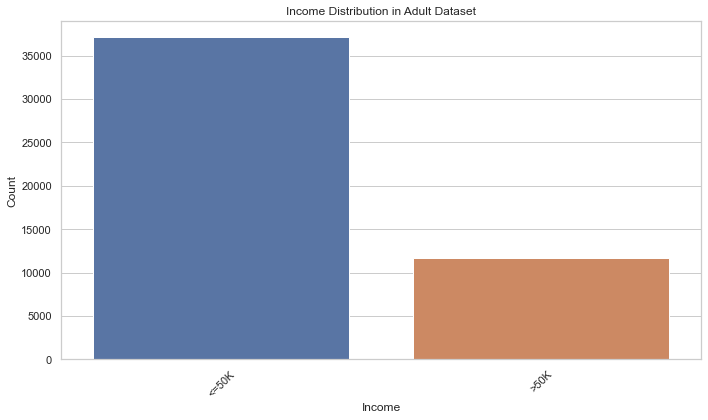

In [10]:
#plotting the income distribution
import matplotlib.pyplot as plt
import seaborn as sns   
# Set the style for seaborn
sns.set(style="whitegrid") 
# Create a bar plot for income distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, x='income', order=combined_df['income'].value_counts().index)
plt.title('Income Distribution in Adult Dataset')
plt.xlabel('Income')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This shows that most people had income less than or equal to 50k which accounts for 76% of total count.
whereelse around 24% were having income greater than 50k  mark

In [ ]:
#Obtaining information about the DataFrame
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       48842 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      48842 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  48842 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [ ]:
#Checking null values in the combined DataFrame
combined_df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64


We find we have no null value in our dataframe

In [7]:
# Find summary statistics of the DataFrame
# This will give us a quick overview of the numerical columns
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education_num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital_gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital_loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours_per_week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


### Observation 
From our summary we establish the average age of the adult income is 38 yrs

We can also see the average working hours from our dataset is 40 hours per week


In [17]:
combined_df['income_numeric'] = combined_df['income'].map({'<=50K': 0, '>50K': 1})

corr_matrix = combined_df.corr()
corr_matrix

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income_numeric
age,1.000000,-0.076628,0.030940,0.077229,0.056944,0.071558,0.230369
fnlwgt,-0.076628,1.000000,-0.038761,-0.003706,-0.004366,-0.013519,-0.006339
education_num,0.030940,-0.038761,1.000000,0.125146,0.080972,0.143689,0.332613
capital_gain,0.077229,-0.003706,0.125146,1.000000,-0.031441,0.082157,0.223013
capital_loss,0.056944,-0.004366,0.080972,-0.031441,1.000000,0.054467,0.147554
hours_per_week,0.071558,-0.013519,0.143689,0.082157,0.054467,1.000000,0.227687
income_numeric,0.230369,-0.006339,0.332613,0.223013,0.147554,0.227687,1.000000


The above  is our Pearson correlation matrix between each numeric feature and our target ("income") which is converted into binary.
From our output we can see 'education_num' with the highest positive correalation(0.3326) with earning >50k implying more years of schooling converts to higher income.

Other features contributing moderately positively to higher income are 'age'(0.2304), 'hours_per_week'(0.2277) and 'capital_gain'(0.2230) respectively .